In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['facialkeypointsdetectionimg', 'resnet50', 'images', 'johnnyships']


In [2]:
import tensorflow as tf
import re
import glob
import cv2

In [3]:
print(os.listdir("../input/johnnyships/johnny_ships_new/images"))

['Validation', 'train', 'test']


In [4]:
NUM_CLASSES = 5

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 25
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [5]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from keras import regularizers

#vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
ResNet50_Conv = ResNet50(weights=resnet_weights_path, include_top=False, pooling = RESNET50_POOLING_AVERAGE)
# Freeze the layers except the last 4 layers
#for layer in ResNet50_Conv.layers[:-1]:
#    layer.trainable = False
 
# Check the trainable status of the individual layers
#for layer in ResNet50_Conv.layers:
#   print(layer, layer.trainable)

model = Sequential()
#model.add(ResNet50(weights=resnet_weights_path, include_top=False, pooling = RESNET50_POOLING_AVERAGE))
model.add(ResNet50_Conv)
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
#model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))


#adding 
#model.add(Dense(2048, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1024, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.5))
#model.add(Dense(512, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.5))

# 2nd layer as Dense for 5-class classification, i.e.,ship classification using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
from tensorflow.python.keras import optimizers

#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [9]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_directory(
        '../input/johnnyships/johnny_ships_new/images/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '../input/johnnyships/johnny_ships_new/images/Validation',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 5989 images belonging to 5 classes.
Found 263 images belonging to 5 classes.


In [10]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 60, 100, 3)

In [11]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../input/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [15]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../input/best.hdf5")

Epoch 1/25
60/60 [==============================] - 20s 327ms/step - loss: 0.2344 - acc: 0.9235 - val_loss: 0.3671 - val_acc: 0.8517
Epoch 2/25
60/60 [==============================] - 19s 310ms/step - loss: 0.2324 - acc: 0.9202 - val_loss: 0.3946 - val_acc: 0.8289
Epoch 3/25
60/60 [==============================] - 19s 312ms/step - loss: 0.2175 - acc: 0.9260 - val_loss: 0.4374 - val_acc: 0.8403
Epoch 4/25
60/60 [==============================] - 19s 315ms/step - loss: 0.2089 - acc: 0.9314 - val_loss: 0.3760 - val_acc: 0.8517


In [16]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


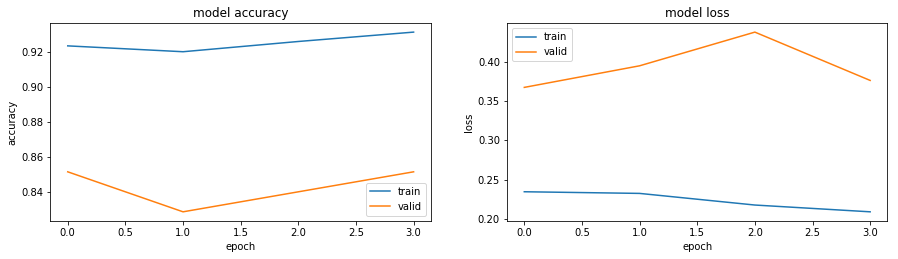

In [17]:
from matplotlib import pyplot as plt
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


In [34]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = '../input/johnnyships/johnny_ships_new/images/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 2680 images belonging to 1 classes.


In [35]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

2680/2680 [==============================] - 47s 18ms/step


In [36]:
predicted_class_indices[30]
#for kl in range (len(predicted_class_indices)):
    #print(predicted_class_indices[kl])
    #predicted_class_indices[kl]=predicted_class_indices[kl]+1
#res = [x + K for x in test_list] 
predicted_class_indices = list(np.asarray(predicted_class_indices) + 1)

In [37]:

def unique(list1): 
    x = np.array(list1) 
    print(np.unique(x)) 

unique(predicted_class_indices)

[1 2 3 4 5]


../input/johnnyships/johnny_ships_new/images/test/All/1011369.jpg


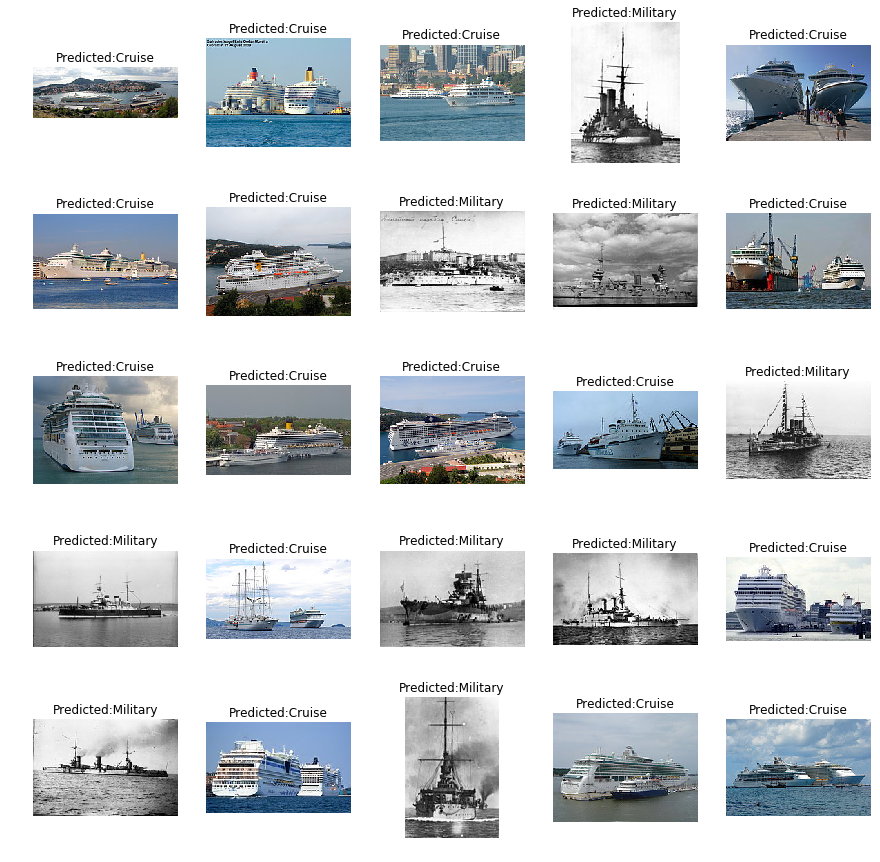

In [38]:
TEST_DIR = '../input/johnnyships/johnny_ships_new/images/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))
Ship_Names= {1:'Cargo', 2:'Military', 
3:'Carrier', 4:'Cruise', 5:'Tankers'}
print(TEST_DIR + test_generator.filenames[1])
for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    # a if condition else b
    predicted_class=Ship_Names[predicted_class_indices[i]]

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [39]:
results_df = pd.DataFrame(
    {
        'image': pd.Series(test_generator.filenames), 
        'category': pd.Series(predicted_class_indices)
    })

results_df['image'] = results_df.image.str.extract('(\d+)')+".jpg"
#results_df['category'] = results_df.image.str.extract('(\d+)')
#results_df['category'] = pd.to_numeric(results_df['category']+1, errors = 'coerce')

#results_df['image'] = pd.to_numeric(results_df['image'], errors = 'coerce')
#results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
